# PROJETO DE SISTEMAS BASEADOS EM APRENDIZADO DE MÁQUINA

Projeto 01 - Problema de Regressão (Airbnb)

Aluna: Luciana Gouveia Machado







O código baixa um arquivo comprimido da internet e depois o descompacta, gerando um arquivo CSV pronto para ser usado, enquanto mantém o original compactado. Para isso é criada a pasta outputs.


In [1]:
!pip install pandas torch matplotlib seaborn
import os
# Use wget to download the dataset
os.makedirs('outputs', exist_ok=True)
if os.path.exists("output/listings.csv.gz"):
    print("Dataset already downloaded.")
else:
    !wget -O output/listings.csv.gz "https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-03-19/data/listings.csv.gz"
    # Unzip the .gz file (-k keeps the original .gz file)
    !gunzip -k output/listings.csv.gz

output/listings.csv.gz: No such file or directory
gzip: output/listings.csv.gz: No such file or directory


In [2]:
# Robust tqdm import: prefer tqdm.auto to avoid notebook-specific AttributeError in tqdm.notebook.__del__
# Place this cell near the top (before any use of tqdm.notebook)
import importlib, sys
try:
    # tqdm.auto selects the best implementation for the environment (notebook/console)
    from tqdm.auto import tqdm
    print('Using tqdm.auto (recommended)')
except Exception as e:
    print('tqdm.auto import failed, falling back to tqdm:', e)
    try:
        from tqdm import tqdm
        print('Using tqdm (fallback)')
    except Exception as e2:
        print('tqdm import failed entirely:', e2)

# Informational: show versions to help debugging if problems persist
try:
    import tqdm
    print('tqdm version:', getattr(tqdm, '__version__', 'unknown'))
except Exception:
    pass
try:
    import ipywidgets as widgets
    print('ipywidgets version:', widgets.__version__)
except Exception:
    pass

# If you still see the AttributeError (tqdm_notebook has no attribute 'disp'), try upgrading tqdm to a newer release and restart the kernel:
#   pip install -U tqdm ipywidgets jupyterlab_widgets
# Then restart the kernel and re-run the notebook.

Using tqdm.auto (recommended)
tqdm version: 4.67.1
ipywidgets version: 8.1.7


In [3]:
# Instalador seguro para ipywidgets / tqdm + fallback amigável
# Tenta importar, se falhar tenta instalar no mesmo ambiente do kernel
import sys, subprocess, importlib
def try_install(pkgs):
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade'] + pkgs)
        return True
    except subprocess.CalledProcessError as e:
        print('pip install failed with error:', e)
        return False

# 1) Check ipywidgets
widgets_ok = False
try:
    import ipywidgets as widgets
    print('ipywidgets available, version', widgets.__version__)
    widgets_ok = True
except Exception as e:
    print('ipywidgets import failed:', e)
    print('Attempting to install ipywidgets and tqdm into the current Python environment...')
    ok = try_install(['ipywidgets', 'tqdm', 'jupyterlab_widgets'])
    if ok:
        try:
            import ipywidgets as widgets
            print('ipywidgets installed, version', widgets.__version__)
            widgets_ok = True
        except Exception as e2:
            print('Still cannot import ipywidgets after install:', e2)
            widgets_ok = False

# 2) Setup tqdm fallback (prefer notebook version when available)
try:
    from tqdm.notebook import tqdm
    print('Using tqdm.notebook')
except Exception as e:
    print('tqdm.notebook not available, using console tqdm -', e)
    from tqdm import tqdm

# 3) If ipywidgets still not OK, print next-steps for the user
if not widgets_ok:
    print('If ipywidgets failed to install, try one of the following:')
    print(' - In a terminal:')
    print()
    print()
    print(' - If you use conda:')
    print('     conda install -c conda-forge ipywidgets jupyterlab_widgets tqdm')
    print(' - If you are in Colab, try restarting the runtime after installing ipywidgets.')
    print('If none of those work, paste the full pip error here (traceback) and I will help diagnose.')

# 4) Quick sanity checks for JupyterLab versions (informational)
try:
    import jupyterlab
    print('jupyterlab version (if installed):', getattr(jupyterlab, '__version__', 'unknown'))
except Exception:
    pass

ipywidgets available, version 8.1.7
Using tqdm.notebook


Esse trecho carrega o arquivo listings.csv no Pandas e trata os espaços excedentes que possam vir nas colunas.

**Modificação:**
Adicionei um tratamento de espaços vazios nas colunas.
``` python
df.columns = [c.strip() for c in df.columns]
```
No atual aparentemente não tem problema por que as colunas não tem espaços extras, mas com outro conjunto de dados pode dar problema.

In [4]:
# Now you have the "listings.csv" file available in Colab
import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv("outputs/listings.csv")
df.columns = [c.strip() for c in df.columns]



**Modificação:**
Visando incluir outros fatores para que o algoritmo possa melhorar a predição do preço, peguei a coluna amenities e transformei ela nas seguintes colunas:
1) parking_free - tem algum estacionamento grátis
2) has_airconditioner - tem arcondicionado
3) pet_allowed - permite pet
4) has_breakfast - tem café da manhã
5) has_gym - tem academia

Para isso foi criada a função parse_amenities. Em seguida desse tratamento é exibida uma visão geral dos dados.

In [5]:
# --- FE: amenities (array JSON em string) ---
import json, re

def parse_amenities(s):
    if not isinstance(s, str):
        return []
    s = s.strip()
    try:
        arr = json.loads(s)
        if isinstance(arr, list):
            return [str(x).lower() for x in arr]
    except Exception:
        # fallback simples: remove colchetes e separa por vírgula
        s2 = s.strip("[]{}")
        return [t.strip().strip('"').strip("'").lower() for t in s2.split(",") if t.strip()]
    return []

if 'amenities' in df.columns:
    am_tokens = df['amenities'].apply(parse_amenities)

    def has_parking_free(tokens):
        # cobre: free parking on premises, free street parking, free parking garage...
        return any(
            ('free parking' in t) or
            (t.startswith('free ') and 'parking' in t) or
            ('free street parking' in t)
            for t in tokens
        )

    def has_breakfast(tokens):
        # cobre: breakfast, breakfast included, free breakfast
        rx = re.compile(r"\bbreakfast\b|breakfast included|free breakfast")
        return int(any(rx.search(t) for t in tokens))

    def has_air_conditioning(tokens):
        rx = re.compile(r"\bair conditioning\b")
        return int(any(rx.search(t) for t in tokens))

    def has_gym(tokens):
        # cobre gym/fitness center
        rx = re.compile(r"\bgym\b|fitness center")
        return int(any(rx.search(t) for t in tokens))

    def has_pets_allowed(tokens):
        rx = re.compile(r"\bpets allowed\b|pet[- ]?friendly")
        return int(any(rx.search(t) for t in tokens))

    # ---- FLAGS ----
    df['parking_free']     = am_tokens.apply(has_parking_free).astype(int)
    df['amen_breakfast']   = am_tokens.apply(has_breakfast).astype(int)
    df['amen_ac']          = am_tokens.apply(has_air_conditioning).astype(int)
    df['amen_gym']         = am_tokens.apply(has_gym).astype(int)
    df['amen_pets_allowed']= am_tokens.apply(has_pets_allowed).astype(int)

    print("Features de amenities adicionadas (somas de 1s):")
    print(df[['parking_free','amen_breakfast','amen_ac','amen_gym','amen_pets_allowed']].sum())
else:
    print("Coluna 'amenities' não encontrada; pulando FE de amenities.")

Features de amenities adicionadas (somas de 1s):
parking_free         18528
amen_breakfast         704
amen_ac              26199
amen_gym              5378
amen_pets_allowed    10457
dtype: int64


Exibe um resumo estrutural do DataFrame (colunas, tipos de dados e valores não nulos).

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42013 entries, 0 to 42012
Data columns (total 84 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            42013 non-null  int64  
 1   listing_url                                   42013 non-null  object 
 2   scrape_id                                     42013 non-null  int64  
 3   last_scraped                                  42013 non-null  object 
 4   source                                        42013 non-null  object 
 5   name                                          42013 non-null  object 
 6   description                                   40982 non-null  object 
 7   neighborhood_overview                         16819 non-null  object 
 8   picture_url                                   42013 non-null  object 
 9   host_id                                       42013 non-null 

Gera um resumo estatístico das colunas numéricas do DataFrame, mostrando contagem, média, desvio padrão, valores mínimo, quartis e máximo.

In [7]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,parking_free,amen_breakfast,amen_ac,amen_gym,amen_pets_allowed
count,4.201300e+04,4.201300e+04,4.201300e+04,42008.000000,42008.000000,0.0,42013.000000,42013.000000,42013.000000,38313.000000,41373.000000,38335.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,0.0,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,3.835600e+04,33140.000000,33139.000000,33140.000000,33139.000000,33139.000000,33139.000000,33139.000000,0.0,42013.000000,42013.000000,42013.000000,42013.000000,33140.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000
mean,7.444710e+17,2.025032e+13,2.256052e+08,14.052466,24.933775,NaN,-22.966277,-43.248424,3.959394,1.497834,1.522297,2.357454,3.609526,366.076738,3.335920,4.209340,452.462071,480.008950,3.653403,463.654781,NaN,17.359175,36.676672,59.122367,188.777878,23.684859,8.113965,0.981268,161.185157,6.993169,49.724823,2.076935e+04,4.802137,4.816212,4.768009,4.886694,4.879855,4.857481,4.719113,NaN,9.338990,8.446433,0.777997,0.110156,1.263767,0.441006,0.016757,0.623593,0.128008,0.248899
std,5.391705e+17,0.000000e+00,2.103432e+08,65.168438,141.331902,NaN,0.035432,0.100336,2.273275,0.971862,1.022382,2.116851,14.249756,379.761816,12.611217,14.462273,428.464379,436.574343,12.928592,426.924469,NaN,11.403082,21.049260,30.761915,128.669915,45.877236,12.482438,1.387351,101.939147,12.096823,69.011854,5.803371e+04,0.389698,0.381337,0.424701,0.313860,0.324846,0.318360,0.432712,NaN,24.426124,24.239087,2.130291,1.194582,1.277616,0.496513,0.128360,0.484490,0.334103,0.432380
min,1.787800e+04,2.025032e+13,3.607000e+03,1.000000,1.000000,NaN,-23.073830,-43.723009,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.625830e+07,2.025032e+13,3.500060e+07,1.000000,1.000000,NaN,-22.984390,-43.300392,2.000000,1.000000,1.000000,1.000000,1.000000,45.000000,1.000000,2.000000,80.000000,89.000000,1.500000,89.000000,NaN,6.000000,19.000000,39.000000,76.000000,1.000000,0.000000,0.000000,72.000000,0.000000,0.000000,0.000000e+00,4.760000,4.790000,4.710000,4.890000,4.890000,4.840000,4.660000,NaN,1.000000,1.000000,0.000000,0.000000,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.494565e+17,2.025032e+13,1.501449e+08,2.000000,3.000000,NaN,-22.971860,-43.193719,4.000000,1.000000,1.000000,2.000000,2.000000,365.000000,2.000000,3.000000,365.000000,365.000000,2.000000,365.000000,NaN,20.000000,42.000000,70.000000,173.000000,6.000000,2.000000,0.000000,167.000000,1.000000,18.000000,6.156000e+03,4.920000,4.930000,4.900000,5.000000,5.000000,4.960000,4.830000,NaN,2.000000,1.000000,0.000000,0.000000,0.930000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.236132e+18,2.025032e+13,4.149635

Esse trecho seleciona apenas colunas específicas do df, cria um novo DataFrame chamado rio_listings com esses dados e mostra 5 linhas aleatórias para conferência.

**Modificado:** Adiciona as 03 colunas especificadas acima.

In [8]:
# Select only the relevant columns from the original dataframe 'df'
# These columns include property features (e.g., accommodates, bathrooms, bedrooms)
# and booking information (e.g., minimum_nights, maximum_nights, number_of_reviews, price).

target_columns = [
    "accommodates",      # Number of guests the property can host
    "bathrooms",         # Number of bathrooms available
    "bedrooms",          # Number of bedrooms available
    "beds",              # Number of beds available
    "minimum_nights",    # Minimum nights required for a booking
    "maximum_nights",    # Maximum nights allowed for a booking
    "number_of_reviews", # Total reviews given by past guests
    "parking_free",      # Has parking free
    "amen_ac",           # Has air conditioner
    "amen_gym",          # Has gym
    "amen_breakfast",    # Has breakfast
    "amen_pets_allowed", # Allows pets
    "price"              # Nightly rental price
]

# Create a new dataframe called 'rio_listings' with only the selected columns
# Using .copy() ensures that we are working with an independent dataframe
# instead of just a view of the original data.

rio_listings = df[target_columns].copy()

# Display a five rows sample of the new dataframe to quickly check the data
rio_listings.sample(5)

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,parking_free,amen_ac,amen_gym,amen_breakfast,amen_pets_allowed,price
40526,4,1.0,1.0,2.0,2,369,0,0,1,0,0,0,$192.00
36490,4,1.0,1.0,2.0,2,365,5,0,1,0,0,0,$368.00
30364,7,1.0,3.0,3.0,1,40,14,1,1,0,0,0,$135.00
1546,6,1.0,2.0,4.0,3,30,0,1,1,0,0,0,"$1,982.00"
12190,4,1.0,1.0,6.0,3,90,2,1,0,1,0,1,$215.00


# Clean, Prepare & Manipulate Data

Esse comando gera estatísticas descritivas (contagem, média, desvio padrão, mínimos, quartis e máximos) para as colunas numéricas do DataFrame rio_listings.

In [9]:
# Generate descriptive statistics
rio_listings.describe()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,parking_free,amen_ac,amen_gym,amen_breakfast,amen_pets_allowed
count,42013.000000,38313.000000,41373.000000,38335.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000
mean,3.959394,1.497834,1.522297,2.357454,3.609526,366.076738,23.684859,0.441006,0.623593,0.128008,0.016757,0.248899
std,2.273275,0.971862,1.022382,2.116851,14.249756,379.761816,45.877236,0.496513,0.484490,0.334103,0.128360,0.432380
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,45.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,1.000000,2.000000,2.000000,365.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,2.000000,3.000000,3.000000,365.000000,26.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,16.000000,20.000000,30.000000,56.000000,1000.000000,1125.000000,726.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Esse comando mostra um resumo do rio_listings, incluindo quantos valores não nulos cada coluna tem — útil para identificar dados ausentes.

In [10]:
# Check missing values
rio_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42013 entries, 0 to 42012
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       42013 non-null  int64  
 1   bathrooms          38313 non-null  float64
 2   bedrooms           41373 non-null  float64
 3   beds               38335 non-null  float64
 4   minimum_nights     42013 non-null  int64  
 5   maximum_nights     42013 non-null  int64  
 6   number_of_reviews  42013 non-null  int64  
 7   parking_free       42013 non-null  int64  
 8   amen_ac            42013 non-null  int64  
 9   amen_gym           42013 non-null  int64  
 10  amen_breakfast     42013 non-null  int64  
 11  amen_pets_allowed  42013 non-null  int64  
 12  price              38356 non-null  object 
dtypes: float64(3), int64(9), object(1)
memory usage: 4.2+ MB


Esse código limpa os valores da coluna price, retirando vírgulas e símbolos de dólar e convertendo os dados para números (float), deixando a coluna pronta para análises.


In [11]:
# Remove commas from the 'price' column (e.g., "$1,200" → "$1200")
stripped_commas = rio_listings['price'].str.replace(',', '')

# Remove dollar signs from the 'price' column (e.g., "$1200" → "1200")
stripped_dollars = stripped_commas.str.replace('$', '')

# Convert the cleaned 'price' column from string to float type
rio_listings['price'] = stripped_dollars.astype('float')

Esse comando remove todas as linhas do rio_listings que contêm valores ausentes em qualquer uma das colunas selecionadas.

In [12]:
# Remove any rows containing missing values across the selected columns
rio_listings.dropna(axis=0, inplace=True)

Esse comando exibe novamente o resumo do rio_listings após a limpeza, mostrando quantas linhas e colunas restaram e se ainda existem valores ausentes.

In [13]:
# Check missing values
rio_listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38242 entries, 0 to 42012
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       38242 non-null  int64  
 1   bathrooms          38242 non-null  float64
 2   bedrooms           38242 non-null  float64
 3   beds               38242 non-null  float64
 4   minimum_nights     38242 non-null  int64  
 5   maximum_nights     38242 non-null  int64  
 6   number_of_reviews  38242 non-null  int64  
 7   parking_free       38242 non-null  int64  
 8   amen_ac            38242 non-null  int64  
 9   amen_gym           38242 non-null  int64  
 10  amen_breakfast     38242 non-null  int64  
 11  amen_pets_allowed  38242 non-null  int64  
 12  price              38242 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 4.1 MB


## Robust IQR-based outlier filtering

“Filtragem robusta de outliers baseada no IQR (Intervalo Interquartil)"

Esse código implementa uma forma robusta de tratar outliers: ele calcula os limites inferior e superior pelo método do IQR (Intervalo Interquartil) e remove, das colunas indicadas do DataFrame, as linhas cujos valores estão fora desses limites.

In [14]:
def _iqr_bounds(series: pd.Series, k: float = 1.5):
    """
    Compute lower/upper bounds for outlier detection using the IQR rule.

    Parameters
    ----------
    series : pd.Series
        Numeric series.
    k : float, default 1.5
        Whisker length multiplier (1.5 = Tukey; 3.0 = more tolerant).

    Returns
    -------
    low : float
        Lower bound (Q1 - k * IQR).
    up : float
        Upper bound (Q3 + k * IQR).
    stats : dict
        Dict with Q1, Q3, IQR.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    up = q3 + k * iqr
    return low, up, {"Q1": q1, "Q3": q3, "IQR": iqr}


def remove_outliers_iqr(
    df: pd.DataFrame,
    columns: list[str],
    k: float = 1.5,
    inclusive: bool = True,
    dropna: bool = True,
):
    """
    Remove rows with outliers per-column using the IQR rule.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str
        Columns to evaluate for outliers (must be numeric or coercible).
    k : float, default 1.5
        Whisker length multiplier (1.5 = standard; 3.0 = lenient).
    inclusive : bool, default True
        If True, keep values exactly on the bounds; otherwise use strict inequality.
    dropna : bool, default True
        If True, drop rows with NaN in the selected columns prior to filtering.

    Returns
    -------
    cleaned : pd.DataFrame
        DataFrame with outlier rows removed.
    info : dict
        Summary with input/output row counts and per-column bounds/statistics.
    """
    data = df.copy()

    # Ensure columns are numeric; non-numeric values become NaN
    for c in columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")

    # Optionally drop NaNs first to avoid excluding entire rows by comparison
    if dropna:
        data = data.dropna(subset=columns)

    before = len(data)
    bounds = {}
    # Start with all rows valid; refine with each column's mask
    mask = pd.Series(True, index=data.index)

    for c in columns:
        low, up, stats = _iqr_bounds(data[c].dropna(), k=k)
        bounds[c] = {"low": low, "up": up, **stats}

        if inclusive:
            m = (data[c] >= low) & (data[c] <= up)
        else:
            m = (data[c] > low) & (data[c] < up)

        mask &= m

    cleaned = data.loc[mask].copy()
    info = {
        "rows_in": before,
        "rows_out": len(cleaned),
        "rows_removed": before - len(cleaned),
        "k": k,
        "inclusive": inclusive,
        "bounds": bounds,
    }
    return cleaned, info

Esse bloco copia o subconjunto rio_listings, aplica a remoção de outliers via IQR (regra de Tukey, k=1.5, limites inclusivos) em todas as colunas alvo, e depois reporta quantas linhas havia antes/depois, quantas foram removidas e os limites/estatísticas (Q1, Q3, IQR) por coluna; por fim, mostra as primeiras linhas do DataFrame filtrado (rio_iqr.head()).

In [15]:
# Assumes you already have:
# - df (your full dataset)
# - target_columns = ["accommodates","bathrooms","bedrooms","beds","minimum_nights",
#                     "maximum_nights","number_of_reviews","price"]
# - rio_listings = df[target_columns].copy()   # your prepared subset

# Copy the dataset to work on IQR filtering
rio_iqr_input = rio_listings[target_columns].copy()

# Remove outliers with default Tukey rule (k=1.5) and inclusive bounds
rio_iqr, summary = remove_outliers_iqr(
    df=rio_iqr_input,
    columns=target_columns,
    k=1.5,
    inclusive=True,
    dropna=True,
)

print(f"Rows before:  {summary['rows_in']}")
print(f"Rows after:   {summary['rows_out']}")
print(f"Removed:      {summary['rows_removed']}")
print("Per-column bounds (low/up):")
for col, b in summary["bounds"].items():
    print(f"  - {col}: [{b['low']:.3f}, {b['up']:.3f}]  (Q1={b['Q1']:.3f}, Q3={b['Q3']:.3f}, IQR={b['IQR']:.3f})")

# Save preprocessed table to outputs/ for downstream notebooks
try:
    rio_iqr.to_parquet('outputs/rio_iqr.parquet')
    print('Saved outputs/rio_iqr.parquet')
except Exception as e:
    print('Could not save rio_iqr.parquet:', e)

rio_iqr.head()

Rows before:  38242
Rows after:   20923
Removed:      17319
Per-column bounds (low/up):
  - accommodates: [-2.500, 9.500]  (Q1=2.000, Q3=5.000, IQR=3.000)
  - bathrooms: [-0.500, 3.500]  (Q1=1.000, Q3=2.000, IQR=1.000)
  - bedrooms: [-0.500, 3.500]  (Q1=1.000, Q3=2.000, IQR=1.000)
  - beds: [-2.000, 6.000]  (Q1=1.000, Q3=3.000, IQR=2.000)
  - minimum_nights: [-2.000, 6.000]  (Q1=1.000, Q3=3.000, IQR=2.000)
  - maximum_nights: [-397.500, 822.500]  (Q1=60.000, Q3=365.000, IQR=305.000)
  - number_of_reviews: [-38.000, 66.000]  (Q1=1.000, Q3=27.000, IQR=26.000)
  - parking_free: [-1.500, 2.500]  (Q1=0.000, Q3=1.000, IQR=1.000)
  - amen_ac: [-1.500, 2.500]  (Q1=0.000, Q3=1.000, IQR=1.000)
  - amen_gym: [0.000, 0.000]  (Q1=0.000, Q3=0.000, IQR=0.000)
  - amen_breakfast: [0.000, 0.000]  (Q1=0.000, Q3=0.000, IQR=0.000)
  - amen_pets_allowed: [-1.500, 2.500]  (Q1=0.000, Q3=1.000, IQR=1.000)
  - price: [-350.000, 1170.000]  (Q1=220.000, Q3=600.000, IQR=380.000)
Saved outputs/rio_iqr.parquet


,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,parking_free,amen_ac,amen_gym,amen_breakfast,amen_pets_allowed,price
2,7,2.0,3.0,6.0,5,90,13,0,1,0,0,0,800.0
4,4,1.0,1.0,2.0,2,28,28,1,1,0,0,0,220.0
5,2,1.0,1.0,1.0,2,730,36,1,1,0,0,0,401.0
7,4,2.0,2.0,2.0,3,30,38,1,0,0,0,0,399.0
8,4,1.0,1.0,2.0,4,90,3,0,1,0,0,0,198.0


Esse comando mostra um resumo estatístico (contagem, média, desvio padrão, valores mínimo, quartis e máximo) apenas da coluna price do DataFrame rio_iqr (já filtrado pelos outliers).

In [16]:
rio_iqr.price.describe()

count    20923.000000
mean       376.847154
std        232.283748
min         44.000000
25%        207.000000
50%        306.000000
75%        486.000000
max       1170.000000
Name: price, dtype: float64

## Correlation Heatmap of Rio Listings Features

“Mapa de calor de correlação das características dos anúncios do Rio”

Esse código calcula a matriz de correlação de Pearson para todas as variáveis do rio_iqr e mostra, em ordem decrescente, como cada feature se relaciona com o preço, ajudando a identificar as mais influentes na previsão.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute pairwise correlation matrix using Pearson's correlation coefficient
corr_matrix = rio_iqr.corr(method="pearson")

# Display features sorted by correlation strength with the target ('price')
# This helps identify which features are most relevant to predict 'price'
price_corr = corr_matrix["price"].sort_values(ascending=False)

print("Correlation of features with target 'price':\n")
print(price_corr)

Correlation of features with target 'price':

price                1.000000
bedrooms             0.425420
accommodates         0.378890
bathrooms            0.378289
beds                 0.287979
minimum_nights       0.166776
amen_ac              0.133946
parking_free         0.097665
amen_pets_allowed   -0.033579
maximum_nights      -0.043142
number_of_reviews   -0.104472
amen_gym                  NaN
amen_breakfast            NaN
Name: price, dtype: float64


Cria uma visualização clara das relações entre as variáveis e o preço.

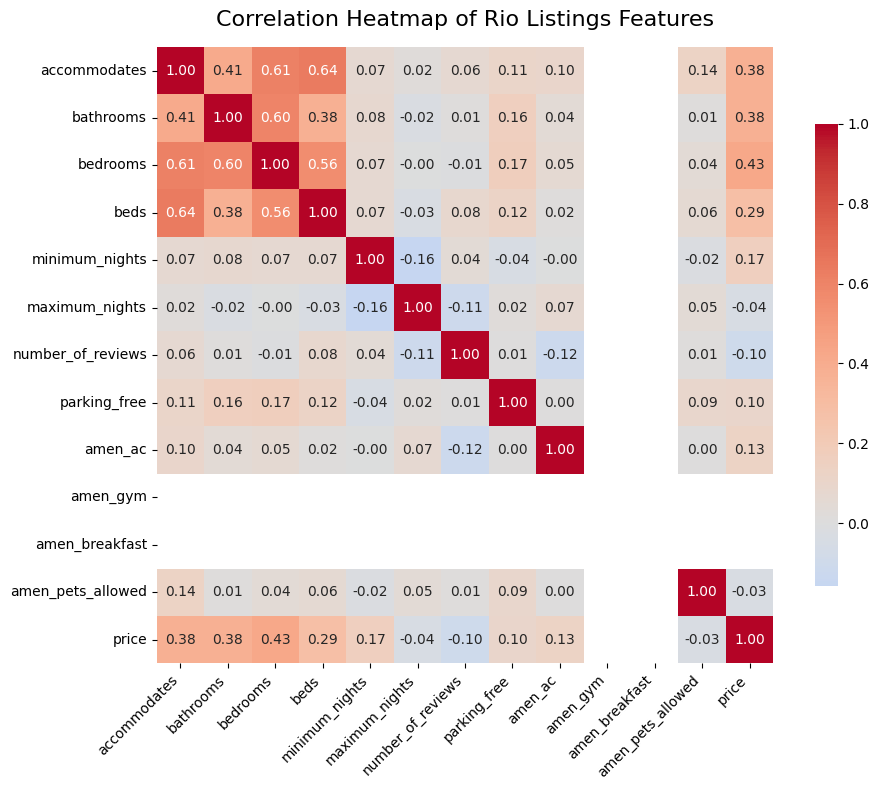

In [18]:
# Visualize correlation matrix

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,          # show correlation values
    fmt=".2f",           # format with 2 decimals
    cmap="coolwarm",     # colormap: negative=blue, positive=red
    center=0,            # center color scale at 0
    square=True,         # square cells
    cbar_kws={"shrink": 0.75}  # adjust colorbar size
)

# Add a title to the heatmap
plt.title("Correlation Heatmap of Rio Listings Features", fontsize=16, pad=15)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Gráficos Box Plot - relação de preço

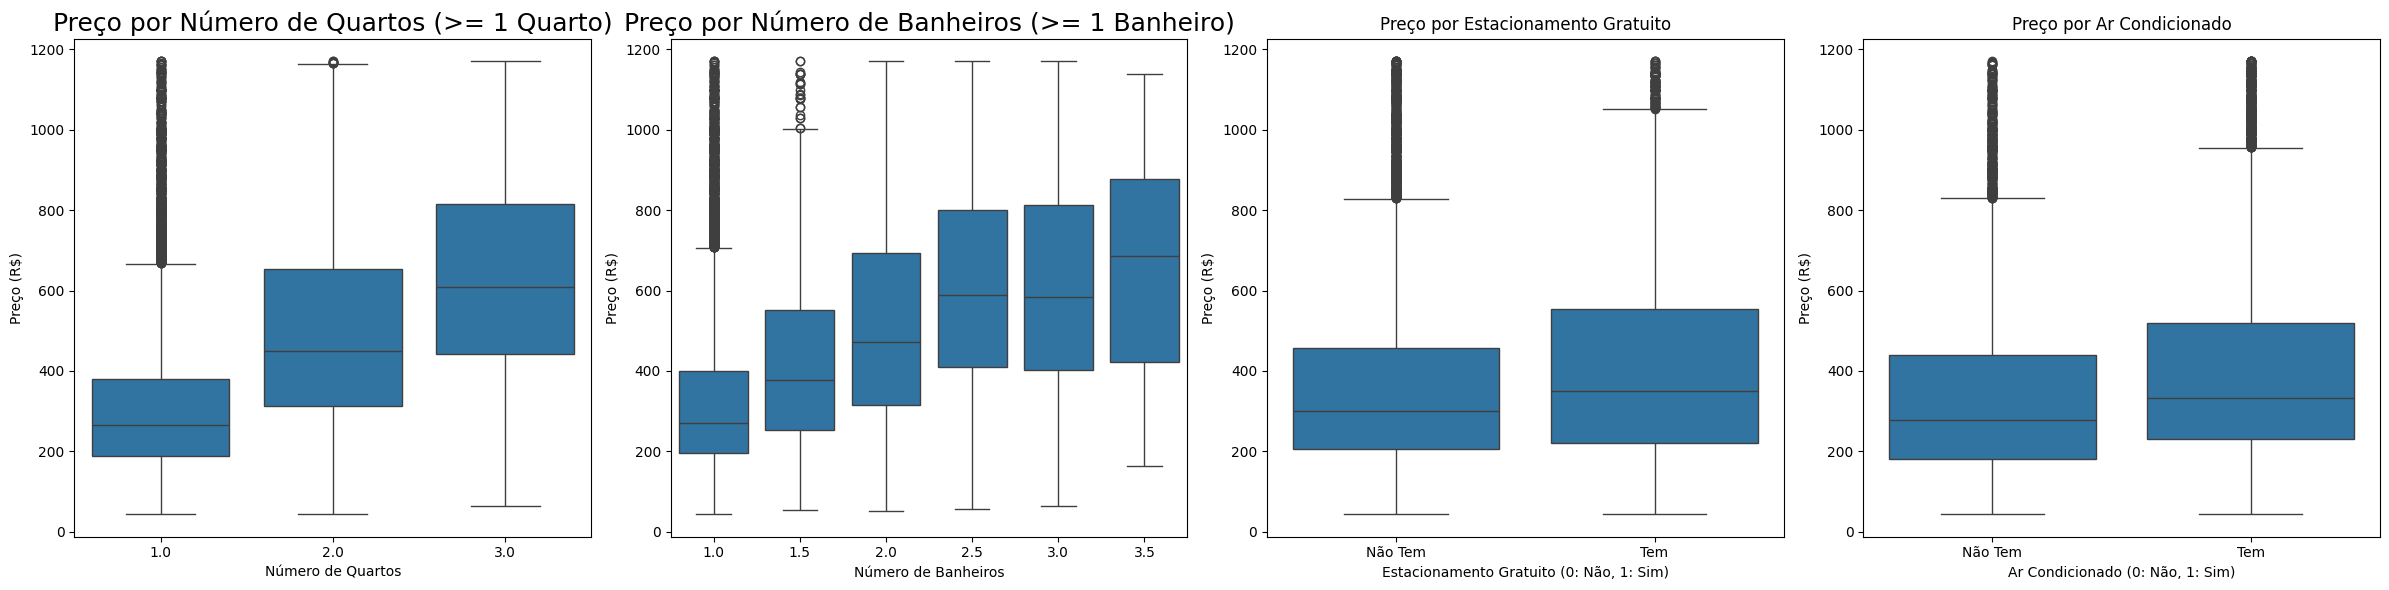

In [19]:
filtered_rio_iqr = rio_iqr[(rio_iqr['bedrooms'] >= 1.0) & (rio_iqr['bathrooms'] >= 1.0)].copy()

# Criar box plots para price vs bedrooms, price vs bathrooms, price vs parking_free, e price vs amen_ac
plt.figure(figsize=(24, 6)) # Increased figure size to accommodate the fourth plot

# Box plot para price por bedrooms (dados filtrados)
plt.subplot(1, 4, 1) # Changed to 1 row, 4 columns
sns.boxplot(x='bedrooms', y='price', data=filtered_rio_iqr)
plt.title('Preço por Número de Quartos (>= 1 Quarto)', fontsize=18)
plt.xlabel('Número de Quartos')
plt.ylabel('Preço (R$)')
#plt.xticks(rotation=45, ha='right') # Rotate x-axis labels

# Box plot para price por bathrooms (dados filtrados)
plt.subplot(1, 4, 2) # Changed to 1 row, 4 columns
sns.boxplot(x='bathrooms', y='price', data=filtered_rio_iqr)
plt.title('Preço por Número de Banheiros (>= 1 Banheiro)', fontsize=18)
plt.xlabel('Número de Banheiros')
plt.ylabel('Preço (R$)')
#plt.xticks(rotation=45, ha='right') # Rotate x-axis labels

# box plot para price por parking_free (dados filtrados)
plt.subplot(1, 4, 3) # Changed to 1 row, 4 columns
sns.boxplot(x='parking_free', y='price', data=filtered_rio_iqr)
plt.title('Preço por Estacionamento Gratuito')
plt.xlabel('Estacionamento Gratuito (0: Não, 1: Sim)')
plt.ylabel('Preço (R$)')
plt.xticks(ticks=[0, 1], labels=['Não Tem', 'Tem']) # Rotate x-axis labels

# Box plot para price por amen_ac (dados filtrados)
plt.subplot(1, 4, 4) # Added the fourth subplot
sns.boxplot(x='amen_ac', y='price', data=filtered_rio_iqr)
plt.title('Preço por Ar Condicionado')
plt.xlabel('Ar Condicionado (0: Não, 1: Sim)')
plt.ylabel('Preço (R$)')
plt.xticks(ticks=[0, 1], labels=['Não Tem', 'Tem'])


plt.tight_layout()
plt.show()

# End-to-End Solution Pipeline in PyTorch

“Pipeline de solução ponta a ponta em PyTorch”

## Import

Esse código importa as bibliotecas necessárias para manipular dados, criar e treinar modelos no PyTorch, dividir conjuntos de dados, otimizar redes neurais e gerar gráficos, além de definir o estilo visual das figuras.

In [20]:
import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
%matplotlib inline
plt.style.use('fivethirtyeight')

## Architecture class

Essa classe encapsula o treinamento, validação, salvamento, predição e visualização das perdas de um modelo PyTorch de forma prática e organizada.

In [21]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

## Data Preparation

Exibe um resumo estrutural do DataFrame após a filtragem de outliers.

In [22]:
rio_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20923 entries, 2 to 42012
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       20923 non-null  int64  
 1   bathrooms          20923 non-null  float64
 2   bedrooms           20923 non-null  float64
 3   beds               20923 non-null  float64
 4   minimum_nights     20923 non-null  int64  
 5   maximum_nights     20923 non-null  int64  
 6   number_of_reviews  20923 non-null  int64  
 7   parking_free       20923 non-null  int64  
 8   amen_ac            20923 non-null  int64  
 9   amen_gym           20923 non-null  int64  
 10  amen_breakfast     20923 non-null  int64  
 11  amen_pets_allowed  20923 non-null  int64  
 12  price              20923 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 2.2 MB


Prepara X (features) e y (alvo) para alimentar o modelo.

In [23]:
# ---------------------------------------------------------------------
# 1) Extract features (X) and target (y) from the DataFrame
# ---------------------------------------------------------------------

# Keep all numeric feature columns except the target 'price'
feature_cols = [c for c in rio_iqr.columns if c != "price"]
target_col   = "price"

# Convert to NumPy arrays (float32 is ideal for PyTorch)
X = rio_iqr[feature_cols].to_numpy(dtype=np.float32)     # shape (N, D)
y = rio_iqr[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)  # shape (N, 1)

# Quick sanity checks
assert not np.isnan(X).any(), "Found NaNs in X. Clean/impute before training."
assert not np.isnan(y).any(), "Found NaNs in y. Clean/impute before training."

cria um conjunto de dados PyTorch completo, pronto para ser dividido em treino e validação ou alimentado diretamente em um DataLoader.

In [24]:
# ---------------------------------------------------------------------
# 2) Build tensors BEFORE splitting (as you requested)
# ---------------------------------------------------------------------

torch.manual_seed(13)

x_tensor = torch.as_tensor(X).float()   # (N, D)
y_tensor = torch.as_tensor(y).float()   # (N, 1)

# Whole dataset
dataset = TensorDataset(x_tensor, y_tensor)

Usa o random_split do PyTorch para fazer a divisão de forma aleatória, garantindo dados separados para treino e teste.

In [25]:
# ---------------------------------------------------------------------
# 3) Train/validation split using PyTorch's random_split
# ---------------------------------------------------------------------
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val   = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

Esse comando retorna o tipo do objeto train_data.
No caso do código acima, ele é um torch.utils.data.dataset.Subset, ou seja, um subconjunto do TensorDataset original (os dados de treino).

In [26]:
type(train_data)

torch.utils.data.dataset.Subset

Esse comando também retorna o tipo do objeto val_data.
Assim como train_data, ele é um torch.utils.data.dataset.Subset, ou seja, um subconjunto do TensorDataset original (os dados de validação).

In [27]:
type(val_data)

torch.utils.data.dataset.Subset

Padroniza os dados (média 0, desvio 1) com base no treino e reaplica isso ao conjunto completo, preservando o split.

In [28]:
# ---------------------------------------------------------------------
# Z-score without leakage
# ---------------------------------------------------------------------
from torch.utils.data import Subset

# 0) Get split indices produced by random_split (already done above)
train_idx = train_data.indices
val_idx   = val_data.indices

# 1) Compute mean/std ONLY on training subset
eps = 1e-8
mu  = x_tensor[train_idx].mean(dim=0)
std = x_tensor[train_idx].std(dim=0, unbiased=False)
std = torch.where(std < eps, torch.ones_like(std), std)  # avoid divide-by-zero

y_mu  = y_tensor[train_idx].mean(dim=0)
y_std = y_tensor[train_idx].std(dim=0, unbiased=False)
y_std = torch.where(y_std < eps, torch.ones_like(y_std), y_std)


# 2) Apply z-score to ALL features using training stats
x_tensor_z = (x_tensor - mu) / std
y_tensor_z = (y_tensor - y_mu) / y_std


# 3) Rebuild dataset with normalized features and REUSE the SAME indices
dataset_z  = TensorDataset(x_tensor_z, y_tensor_z)
train_data = Subset(dataset_z, train_idx)
val_data   = Subset(dataset_z, val_idx)
# Persist scalers and indices into outputs/ for other notebooks
import os, json
os.makedirs('outputs', exist_ok=True)
# Convert to numpy for portability; y_mu/y_std may be tensors
try:
    mu_np = mu.detach().cpu().numpy() if hasattr(mu, 'detach') else (mu if mu is None else np.asarray(mu))
    std_np = std.detach().cpu().numpy() if hasattr(std, 'detach') else (std if std is None else np.asarray(std))
except Exception:
    mu_np = np.asarray(mu) if mu is not None else None
    std_np = np.asarray(std) if std is not None else None
# y scalers as floats
def _to_float_or_none(x):
    try:
        if x is None: return None
        if hasattr(x, 'item'): return float(x.item())
        a = np.asarray(x)
        if a.size == 1: return float(a.flatten()[0])
    except Exception:
        return None
    return None
y_mu_f = _to_float_or_none(y_mu)
y_std_f = _to_float_or_none(y_std)

import torch
scalers = {'mu': mu_np, 'std': std_np, 'y_mu': y_mu_f, 'y_std': y_std_f}
try:
    torch.save(scalers, 'outputs/scalers.pt')
    print('Saved outputs/scalers.pt')
except Exception as e:
    print('Failed to save outputs/scalers.pt:', e)
# Save feature order
try:
    if 'feature_cols' in globals():
        with open('outputs/feature_cols.json','w',encoding='utf-8') as f:
            json.dump(feature_cols, f, ensure_ascii=False)
        print('Saved outputs/feature_cols.json')
except Exception as e:
    print('Failed to save outputs/feature_cols.json:', e)
# Save indices
try:
    np.save('outputs/train_idx.npy', train_idx)
    np.save('outputs/val_idx.npy', val_idx)
    print('Saved outputs/train_idx.npy and outputs/val_idx.npy')
except Exception as e:
    print('Failed to save train/val indices:', e)

Saved outputs/scalers.pt
Saved outputs/feature_cols.json
Saved outputs/train_idx.npy and outputs/val_idx.npy


Prepara os carregadores de dados (DataLoaders) para treino e validação com batchs definidos.

In [29]:
# 4) Recreate the DataLoaders
batch_size  = 16
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset=val_data,   batch_size=batch_size, shuffle=False)

# Quick peek to confirm shapes
xb, yb = next(iter(train_loader))
print(f"Train batch X: {xb.shape} | y: {yb.shape}")  # e.g., (16, D) and (16, 1)

Train batch X: torch.Size([16, 12]) | y: torch.Size([16, 1])


## Model Configuration

Configura um modelo linear de regressão no PyTorch com otimização SGD e perda MSE.

**Modificação:** Otimizador Adam

In [30]:
# 5) (Optional but safer) Make model input dimension dynamic
# Sets learning rate
lr = 0.001
torch.manual_seed(42)
D = x_tensor.shape[1]  # number of features
model = nn.Sequential(nn.Linear(D, 1))
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

## Training

Inicia e executa todo o processo de treinamento do modelo.

In [31]:
n_epochs = 100
arch = Architecture(model, loss_fn, optimizer)
arch.set_seed(42)
arch.set_loaders(train_loader, val_loader)
arch.train(n_epochs=n_epochs)

Plota a curva de aprendizado, mostrando se o modelo está convergindo bem durante o treino.

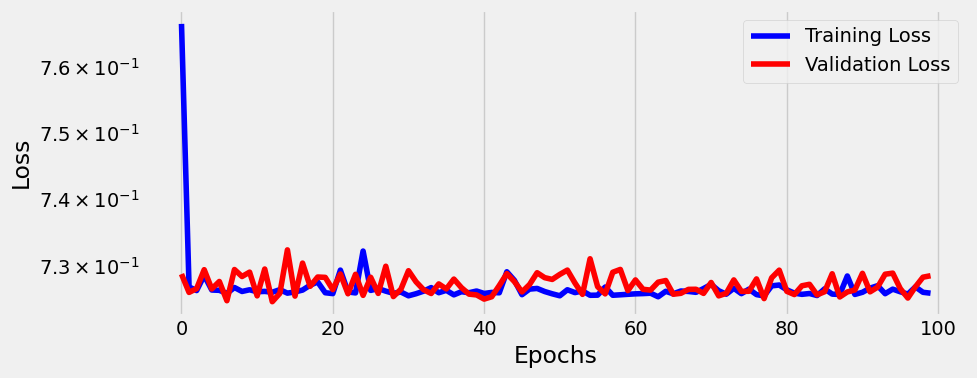

In [32]:
dfig = arch.plot_losses()

Exibe um panorama estrutural atualizado do DataFrame filtrado.

In [33]:
rio_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20923 entries, 2 to 42012
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       20923 non-null  int64  
 1   bathrooms          20923 non-null  float64
 2   bedrooms           20923 non-null  float64
 3   beds               20923 non-null  float64
 4   minimum_nights     20923 non-null  int64  
 5   maximum_nights     20923 non-null  int64  
 6   number_of_reviews  20923 non-null  int64  
 7   parking_free       20923 non-null  int64  
 8   amen_ac            20923 non-null  int64  
 9   amen_gym           20923 non-null  int64  
 10  amen_breakfast     20923 non-null  int64  
 11  amen_pets_allowed  20923 non-null  int64  
 12  price              20923 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 2.2 MB


mostra como normalizar, predizer e reverter a normalização para obter o valor real previsto.

In [34]:
# -------------------------------------------------------------
# Suppose you trained and still have mu, std (for X) and y_mu, y_std (for y)
# -------------------------------------------------------------
# Example: one new sample with 12 features (same order as feature_cols)
# The order of features should match the order in feature_cols:
# accommodates, bathrooms, bedrooms, beds, minimum_nights, maximum_nights, number_of_reviews, parking_free, amen_ac
X_new = np.array([[2.0, 1.0, 2.0, 2.0, 4.0, 100.0, 30.0, 1.0, 1.0, 1.0, 1.0, 1.0]], dtype=np.float32)
# (this is just a made-up input)

# -------------------------------------------------------------
# 1) Apply the SAME feature normalization (z-score using training mu/std)
# -------------------------------------------------------------
X_new_t = torch.as_tensor(X_new)
X_new_norm = (X_new_t - mu) / std  # mu, std from TRAIN only

# -------------------------------------------------------------
# 2) Predict with your trained Architecture
# -------------------------------------------------------------
y_pred_z = arch.predict(X_new_norm.numpy())   # prediction in standardized space of y

# -------------------------------------------------------------
# 3) Revert target normalization back to original units
# -------------------------------------------------------------
y_pred_real = y_pred_z * y_std.item() + y_mu.item()

# Convert to scalar
y_pred_real_value = float(y_pred_real.squeeze())

print(f"Predicted price: R$ {y_pred_real_value:.2f}")

Predicted price: R$ 392.64


# Gerando leaderboard para comparar com as outras ferramentas

In [35]:
# ---------------------------------------------------------------------
# 1) Extract features (X) and target (y) from the DataFrame
# ---------------------------------------------------------------------

# Keep all numeric feature columns except the target 'price'
feature_cols = [c for c in rio_iqr.columns if c != "price"]
target_col   = "price"

# Convert to NumPy arrays (float32 is ideal for PyTorch)
X = rio_iqr[feature_cols].to_numpy(dtype=np.float32)     # shape (N, D)
y = rio_iqr[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)  # shape (N, 1)

# Quick sanity checks
assert not np.isnan(X).any(), "Found NaNs in X. Clean/impute before training."
assert not np.isnan(y).any(), "Found NaNs in y. Clean/impute before training."

In [36]:
# --- Robust leaderboard recomputation (PyTorch-only) ---
import os
import json
import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

print('Checando disponibilidade de GPU...')
print('torch.cuda.is_available():', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU(s):', [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

# Ensure required variables exist (if running interactively). The notebook can also run purely from saved outputs.
required = []
# We prefer using the canonical outputs/ artifacts; if you are running from a live session where `arch` is present it will be used.

# Load canonical artifacts from outputs/ if present
from pathlib import Path
ROOT = Path('.')
OUT = ROOT / 'outputs'

if not OUT.exists():
    raise FileNotFoundError('Directory outputs/ not found. Run the data-prep or training notebook save cells first.')

# Load preprocessed table and indices
rio_path = OUT / 'rio_iqr.parquet'
feat_path = OUT / 'feature_cols.json'
train_idx_path = OUT / 'train_idx.npy'
val_idx_path = OUT / 'val_idx.npy'

for p in (rio_path, feat_path, train_idx_path, val_idx_path):
    if not p.exists():
        raise FileNotFoundError(f'Required artifact missing: {p}. Run 00_data_prep.ipynb or the save cells in your training notebook.')

rio_iqr = pd.read_parquet(rio_path)
with open(feat_path, 'r', encoding='utf-8') as f:
    feature_cols = json.load(f)
train_idx = np.load(train_idx_path, allow_pickle=False)
val_idx = np.load(val_idx_path, allow_pickle=False)

# Build arrays
feature_cols = [c for c in feature_cols if c in rio_iqr.columns]
X = rio_iqr[feature_cols].to_numpy(dtype=np.float32)
y = rio_iqr['price'].to_numpy(dtype=np.float32).ravel()
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print('Loaded artifacts from outputs/. Shapes:')
print('  full X:', X.shape, 'y:', y.shape)
print('  X_train:', X_train.shape, 'X_val:', X_val.shape)
print('  y_train:', y_train.shape, 'y_val:', y_val.shape)

# Load scalers if available (saved in globals or outputs)
def to_cpu_np(x):
    if x is None:
        return None
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

mu = None
std = None
y_mu = None
y_std = None

# Try to load scalers from outputs/scalers.pt using a safe loader when present
scalers_file = OUT / 'scalers.pt'
if scalers_file.exists():
    try:
        def safe_torch_load(path):
            path = str(path)
            try:
                return torch.load(path, map_location='cpu')
            except Exception:
                try:
                    return torch.load(path, map_location='cpu', weights_only=False)
                except Exception:
                    try:
                        torch.serialization.add_safe_globals(["numpy.core.multiarray._reconstruct"])
                        return torch.load(path, map_location='cpu')
                    except Exception as e:
                        raise RuntimeError(f'Failed to load scalers {path}: {e}') from e
        scalers = safe_torch_load(scalers_file)
        # Expect scalers to be a dict with 'mu','std','y_mu','y_std' (or numpy arrays)
        if isinstance(scalers, dict):
            mu = scalers.get('mu')
            std = scalers.get('std')
            y_mu = scalers.get('y_mu')
            y_std = scalers.get('y_std')
    except Exception as e:
        print('Aviso: não foi possível carregar outputs/scalers.pt — continuando sem normalização:', e)

# Coerce scalers to numpy if they are tensors
mu = to_cpu_np(mu)
std = to_cpu_np(std)
y_mu = to_cpu_np(y_mu)
y_std = to_cpu_np(y_std)

# Predict with PyTorch model: prefer using in-memory `arch` if available, otherwise rely on saved predictions
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando device para inferência:', device)

model = None
if 'arch' in globals() and getattr(globals().get('arch'), 'model', None) is not None:
    model = globals().get('arch').model

# Normalize X_val if scalers available
X_val_proc = X_val.copy()
if mu is not None and std is not None:
    try:
        X_val_proc = (X_val_proc - np.asarray(mu).reshape(1, -1)) / (np.asarray(std).reshape(1, -1) + 1e-12)
    except Exception as e:
        print('Aviso: não foi possível normalizar X_val com mu/std:', e)

# Helper for batching
def batch_predict_model(model, npX, batch_size=512, device='cpu'):
    model = model.to(device)
    model.eval()
    preds = []
    for i in range(0, npX.shape[0], batch_size):
        xb = torch.from_numpy(npX[i:i+batch_size]).float().to(device)
        with torch.no_grad():
            yb = model(xb).cpu().numpy()
        preds.append(yb)
    return np.vstack(preds).squeeze()

# First try: load pre-saved predictions
pred_path_np = OUT / 'pytorch_predictions.npy'
pred_path_pkl = OUT / 'pytorch_predictions.pkl'
y_pred = None
if pred_path_np.exists():
    y_pred = np.load(pred_path_np, allow_pickle=False)
    print('Loaded predictions from', pred_path_np)
elif pred_path_pkl.exists():
    y_pred = pd.read_pickle(pred_path_pkl)
    y_pred = np.asarray(y_pred).ravel()
    print('Loaded predictions from', pred_path_pkl)
else:
    # If we have an in-memory model, run it
    if model is not None:
        print('Running inference with in-memory arch.model...')
        model = model.to(device)
        t0 = time.time()
        y_pred_pt = batch_predict_model(model, X_val_proc, batch_size=256, device=device)
        t1 = time.time()
        print(f'Inferência concluída em {t1-t0:.2f}s para {X_val_proc.shape[0]} amostras')
        # inverse transform if y scalers available
        if (y_mu is not None) and (y_std is not None):
            y_pred = y_pred_pt * float(y_std) + float(y_mu)
        else:
            y_pred = y_pred_pt
    else:
        # Try best-effort to read predictions from a checkpoint dict
        def safe_torch_load(path):
            path = str(path)
            try:
                return torch.load(path, map_location='cpu')
            except Exception:
                try:
                    return torch.load(path, map_location='cpu', weights_only=False)
                except Exception:
                    try:
                        torch.serialization.add_safe_globals(["numpy.core.multiarray._reconstruct"])
                        return torch.load(path, map_location='cpu')
                    except Exception as e:
                        raise RuntimeError(f'Failed to load checkpoint {path}: {e}') from e
        ckpt_candidates = [OUT / 'model.ckpt', OUT / 'model_state_dict.pt', OUT / 'model.pt']
        ckpt = None
        for p in ckpt_candidates:
            if p.exists():
                try:
                    ckpt = safe_torch_load(p)
                    print('Loaded checkpoint from', p)
                    break
                except Exception as e:
                    print('Could not load', p, '->', e)
        if ckpt is not None and isinstance(ckpt, dict):
            for key in ('predictions', 'y_pred', 'val_preds', 'preds'):
                if key in ckpt:
                    y_pred = np.asarray(ckpt[key]).ravel()
                    print('Extracted predictions from checkpoint key:', key)
                    break

if y_pred is None:
    raise RuntimeError('No saved PyTorch predictions found in outputs/ and no in-memory model available. Please save predictions to outputs/pytorch_predictions.npy or run the training notebook with the model in memory.')

# Ensure shapes match
y_pred = np.asarray(y_pred).ravel()
if y_pred.shape[0] != y_val.shape[0]:
    raise ValueError(f'Prediction length {y_pred.shape[0]} does not match y_val length {y_val.shape[0]}')

# Compute metrics
pt_rmse = float(np.sqrt(mean_squared_error(y_val, y_pred)))
pt_mae = float(mean_absolute_error(y_val, y_pred))
pt_r2 = float(r2_score(y_val, y_pred))
pt_row = pd.DataFrame([{'Model': 'Seu modelo (PyTorch)', 'RMSE': pt_rmse, 'MAE': pt_mae, 'R2': pt_r2}])

leaderboard = pt_row.copy()
leaderboard = leaderboard.sort_values('RMSE').reset_index(drop=True)
print('Desempenho do modelo PyTorch:')
display(leaderboard)

os.makedirs(OUT, exist_ok=True)
leaderboard.to_csv(OUT / 'leaderboard_airbnbprediction.csv', index=False)
np.save(OUT / 'pytorch_predictions.npy', y_pred)
print('Salvo: outputs/leaderboard_airbnbprediction.csv e outputs/pytorch_predictions.npy')

Checando disponibilidade de GPU...
torch.cuda.is_available(): False
Loaded artifacts from outputs/. Shapes:
  full X: (20923, 12) y: (20923,)
  X_train: (16738, 12) X_val: (4185, 12)
  y_train: (16738,) y_val: (4185,)
Usando device para inferência: cpu
Running inference with in-memory arch.model...
Inferência concluída em 0.00s para 4185 amostras
Desempenho do modelo PyTorch:


,Model,RMSE,MAE,R2
0,Seu modelo (PyTorch),199.040531,150.607391,0.237717


Salvo: outputs/leaderboard_airbnbprediction.csv e outputs/pytorch_predictions.npy


# Gradio demo (in-notebook)

As opções abaixo permitem: (1) salvar os artefatos treinados (checkpoint e scalers) em disco e
(2) iniciar um servidor Gradio dentro do mesmo kernel usando as variáveis já presentes (por exemplo `arch`, `mu`, `std`, `y_mu`, `y_std`, `feature_cols`).

Nota: não instalamos pacotes automaticamente — se `gradio` não estiver disponível, rode `pip install gradio` no seu `.venv` e re-execute a célula.

In [38]:
!pip install gradio torch pandas numpy scikit-learn tqdm ipywidgets
# Save model checkpoint and scalers (so the Gradio app or external services can load them)
import torch
import os

# Save model checkpoint using Architecture.save_checkpoint if available (outputs/)
os.makedirs('outputs', exist_ok=True)
try:
    arch.save_checkpoint('outputs/model.ckpt')
    print('Saved outputs/model.ckpt')
except Exception as e:
    print('Could not save model via arch.save_checkpoint (trying state_dict):', e)
    # As a fallback, try saving model.state_dict() only
    try:
        torch.save(arch.model.state_dict(), 'outputs/model_state_dict.pt')
        print('Saved outputs/model_state_dict.pt')
    except Exception as e2:
        print('Fallback save failed:', e2)

# Save scalers (mu/std/y_mu/y_std) if they exist
scalers = {}
if 'mu' in globals() and 'std' in globals():
    try:
        scalers['mu'] = mu
        scalers['std'] = std
    except Exception as e:
        print('Could not capture mu/std:', e)
if 'y_mu' in globals() and 'y_std' in globals():
    try:
        scalers['y_mu'] = y_mu
        scalers['y_std'] = y_std
    except Exception as e:
        print('Could not capture y_mu/y_std:', e)

if scalers:
    try:
        torch.save(scalers, 'outputs/scalers.pt')
        print('Saved outputs/scalers.pt')
    except Exception as e:
        print('Failed to save outputs/scalers.pt:', e)
    # Also save feature column order so external apps can build the inputs in the same order
    try:
        import json
        if 'feature_cols' in globals():
            with open('outputs/feature_cols.json','w',encoding='utf-8') as f:
                json.dump(feature_cols, f, ensure_ascii=False)
            print('Saved outputs/feature_cols.json')
        else:
            print('feature_cols not found in notebook namespace; outputs/feature_cols.json not written')
    except Exception as e:
        print('Failed to save feature_cols.json:', e)
else:
    print('No scaler variables found in the notebook namespace; skipping scalers save.')

Saved outputs/model.ckpt
Saved outputs/scalers.pt
Saved outputs/feature_cols.json


## Comparação de performance entre os algoritmos

Pega todos os arquivos que começam com "leaderboard_"

In [39]:
import os
import pandas as pd

# Lista todos os arquivos na pasta atual que começam com 'leaderboard_' e terminam com '.csv'
files = [f for f in os.listdir('./outputs') if f.startswith('leaderboard_') and f.endswith('.csv')]
if not files:
    print('No leaderboard CSV files found in current dir or outputs/. Checking outputs/ for diagnostics...')
    try:
        print('files in outputs/:', sorted([p for p in os.listdir('outputs') if p.endswith('.csv')]))
    except Exception as e:
        print('Could not list outputs/:', e)
else:
    dfs = []
    for fp in files:
        try:
            df = pd.read_csv(os.path.join('outputs',fp))
        except Exception as e:
            print(f'Could not read {fp}: {e} -- skipping')
            continue
        # Normalize common column names (case-insensitive)
        cols_lower = {c.lower(): c for c in df.columns}
        # Find RMSE column (required); try common variants
        rmse_col = None
        for candidate in ('rmse', 'r m s e', 'root_mean_squared_error'):
            if candidate in cols_lower:
                rmse_col = cols_lower[candidate]
                break
        # fallback: any column that contains 'rmse' substring
        if rmse_col is None:
            for k, orig in cols_lower.items():
                if 'rmse' in k:
                    rmse_col = orig
                    break
        if rmse_col is None:
            print(f'File {fp} has no RMSE-like column; skipping')
            continue
        rename_map = {rmse_col: 'RMSE'}
        # optional MAE and R2
        for target in ('mae','r2'):
            if target in cols_lower:
                rename_map[cols_lower[target]] = target.upper()
        df = df.rename(columns=rename_map)
        # Ensure there's a Model column
        if 'Model' not in df.columns:
            # try common alternatives
            if 'model' in cols_lower:
                df = df.rename(columns={cols_lower['model']: 'Model'})
            else:
                # create a model column from filename if needed
                df['Model'] = os.path.splitext(os.path.basename(fp))[0]
        df['source_file'] = os.path.basename(fp)
        df['source_dir'] = os.path.dirname(fp)
        dfs.append(df)
    if not dfs:
        print('No valid leaderboard dataframes were found after parsing files. Check that files contain an RMSE column and are valid CSVs.')
    else:
        all_leaderboards = pd.concat(dfs, ignore_index=True, sort=False)
        # Coerce RMSE to numeric and drop rows without RMSE
        all_leaderboards['RMSE'] = pd.to_numeric(all_leaderboards['RMSE'], errors='coerce')
        all_leaderboards = all_leaderboards.dropna(subset=['RMSE'])
        all_leaderboards = all_leaderboards.sort_values('RMSE').reset_index(drop=True)
        # Display top results
        print('Top 20 models by RMSE (lower is better):')
        display(all_leaderboards.head(20))
        # Save merged leaderboard to outputs/
        OUT = Path('outputs')
        OUT.mkdir(parents=True, exist_ok=True)
        out_path = OUT / 'top_20.csv'
        all_leaderboards.to_csv(out_path, index=False)
        print(f'Saved merged leaderboard to {out_path}')
        # Also show best per source_file
        best_per_source = all_leaderboards.groupby('source_file', as_index=False).first().sort_values('RMSE').reset_index(drop=True)


Top 20 models by RMSE (lower is better):


,Model,RMSE,MAE,R2,source_file,source_dir
0,GradientBoostingRegressor,192.546241,NaN,NaN,leaderboard_lazypredict.csv,
1,LGBMRegressor,192.564594,NaN,NaN,leaderboard_lazypredict.csv,
2,HistGradientBoostingRegressor,192.638059,NaN,NaN,leaderboard_lazypredict.csv,
3,MLPRegressor,194.693640,NaN,NaN,leaderboard_lazypredict.csv,
4,XGBRegressor,197.964683,NaN,NaN,leaderboard_lazypredict.csv,
5,ElasticNetCV,198.538341,NaN,NaN,leaderboard_lazypredict.csv,
6,Lasso,198.659541,NaN,NaN,leaderboard_lazypredict.csv,
7,LassoLars,198.659541,NaN,NaN,leaderboard_lazypredict.csv,
8,LassoCV,198.748919,NaN,NaN,leaderboard_lazypredict.csv,
9,BayesianRidge,198.750501,NaN,NaN,leaderboard_lazypredict.csv,


Saved merged leaderboard to outputs/top_20.csv
